# Demo: openEO Python Client Library using the VITO/Terrascope backend

This is an illustration of using the [openEO Python Client Library](https://open-eo.github.io/openeo-python-client/)
with the VITO/[Terrascope](https://terrascope.be) backend,
as demonstrated on the [joint openEO/Terrascope webinar](https://terrascope.be/en/news-events/joint-openeo-terrascope-webinar) on March 30, 2021.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import scipy.signal
import shapely.geometry
import pathlib

import openeo
from openeo.rest.job import RESTJob
from openeo.rest.conversions import timeseries_json_to_pandas

%matplotlib inline

In [2]:
DEFAULT_FIGSIZE = (5, 4)

def show_tiff(filename:str, figsize=DEFAULT_FIGSIZE, vmin=None, vmax=None, rescale_percentile=97, add_colorbar=False):
    """Small helper to load a geotiff and visualize it"""
    with rasterio.open(filename) as ds:
        data = ds.read()

    fig, ax = plt.subplots(figsize=figsize)

    if len(data.shape) == 3:
        if data.max() > 500:
            p = np.percentile(data, rescale_percentile, axis=[1,2])
            data = data / p[:, None, None]
            data = np.clip(data, 0, 1)
        data = np.moveaxis(data, 0, 2)
        
    im = ax.imshow(data, vmin=vmin, vmax=vmax)
    if add_colorbar:
        fig.colorbar(im, ax=ax, fraction=0.05)

out_dir = pathlib.Path("openeo-terrascope-webinar-results")
out_dir.mkdir(parents=True, exist_ok=True)

In [3]:
openeo.client_version()

'0.6.2a1'

# Create a connection

It all starts with creating a connection to the desired openEO backend as follows:

In [4]:
con = openeo.connect("https://openeo.vito.be")
con

<Connection to 'https://openeo.vito.be/openeo/1.0/' with NullAuth>

Using this `Connection` object, we can list available data collections and inspect other metadata.

In [5]:
# con.list_collections()

In [6]:
# con.describe_collection("TERRASCOPE_S2_TOC_V2")

In [7]:
# con.list_processes()

## Authentication with OpenID Connect

To be able to do actual processing, we have to authenticate first, 
so that the backend knows which user is using which processing resources.

We can authenticate with OpenID Connect easily with the following method.
It will first attempt to use existing refresh tokens
and if that failed, the "device code" flow will be initiated.

In [8]:
con.authenticate_oidc(provider_id="egi")

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.0/' with BearerAuth>

To see if authentication worked properly, we can inspect the user information that the backend received:

In [9]:
con.describe_account()["info"]["name"]

'Stefaan Lippens'

# General workflow

We start easy by just requesting Sentinel-2 RGB data for a small bounding box.

First we build the query or algorithm by constructing a data cube.


In [10]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]
dates = ("2021-03-06", "2021-03-07")

In [11]:
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=bands)
cube = cube.filter_bbox(bbox=bbox)
cube = cube.filter_temporal(dates)

The thing we constructed here is a `DataCube` object, which is a symbolic representation of the operations we want to do:

In [12]:
cube

Now "execute" the algorithm by triggering a synchronous download:

In [13]:
cube.download(out_dir / "basic.tiff", format="GTIFF")

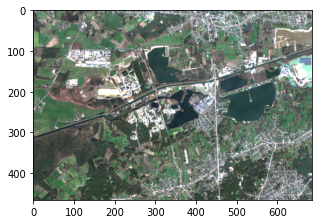

In [14]:
show_tiff(out_dir / "basic.tiff")

# "Band math": NDVI

To illustrate the "band math" feature of the openEO Python Client Libaray
we will calculate the NDVI (Normalized Difference Vegetation Index)
which is a popular indicator for the amount of vegation based on near-infrared ("NIR") and red bands of Sentinel-2:

$$ \mathrm{NDVI} = \frac{\mathrm{NIR} - \mathrm{Red}}{\mathrm{NIR} + \mathrm{Red}} $$


In [15]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
dates = ("2021-03-06", "2021-03-07")
bands = ["B04", "B08"]

# Note that we can specify bounding box and temporal extent directly in the `load_collection` process
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)

Pick the red and NIR bands:

In [16]:
red = cube.band("B04")
nir = cube.band("B08")

Use mathematical operators on these bands, to calculate the NDVI.

In [17]:
ndvi = (nir - red) / (nir + red)

Note that the above expression does not involve actual calculations (like when you use floats or numpy arrays).
We are just working with symbolic representations that we assemble together as desired to construct an algorithm.
For example: the `ndvi` variable is just a `DataCube` object:

In [18]:
ndvi

If you're interested, you can inspect the JSON-representation of the DataCube we will send to the backend:

In [19]:
# print(ndvi.to_json())

Now, execute this data cube on the backend and download the result:

In [20]:
ndvi.download(out_dir / "ndvi.tiff", format="GTiff")

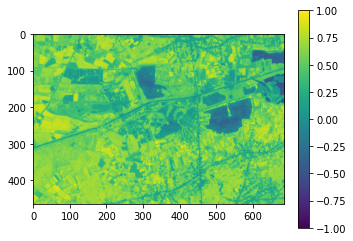

In [21]:
show_tiff(out_dir / "ndvi.tiff", vmin=-1, vmax=1, add_colorbar=True)

# Cloud masking

On some dates, the observation can be ruined because of clouds and we want to filter out those pixels.
We can do that with the help of the scene classification layer `SCL` of the `TERRASCOPE_S2_TOC_V2` collection.

Take this date for example:

In [22]:
dates = ("2020-07-21", "2020-07-22")

bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
bands = ["B04", "B03", "B02"]

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", spatial_extent=bbox, temporal_extent=dates, bands=bands)
cube.download(out_dir / "basic-clouded.tiff", format="GTIFF")

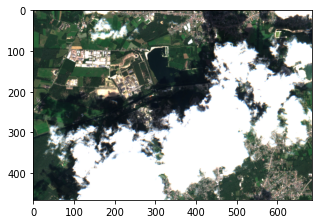

In [23]:
show_tiff(out_dir / "basic-clouded.tiff", rescale_percentile=70)

Let's load the data to calculate the NDVI and to get the scene classification.

In [24]:
bbox = {"west": 5.05, "south": 51.20, "east": 5.15, "north": 51.24, "crs": "EPSG:4326"}
dates = ("2020-07-21", "2020-07-22")

bands = ["B04", "B08", "SCL"]

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", temporal_extent=dates, spatial_extent=bbox, bands=bands)

In [25]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)
ndvi.download(out_dir / "ndvi-clouded.tiff", format="GTiff")

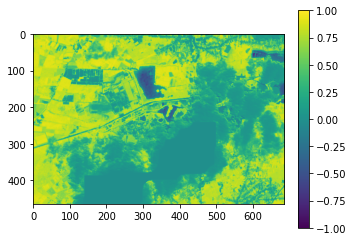

In [26]:
show_tiff(out_dir / "ndvi-clouded.tiff", vmin=-1, vmax=1, add_colorbar=True)

The clouds are clearly ruining the NDVI data.


To filter out the cloudy pixels: let's create a cloud mask based on the scene classification band.

In [27]:
classification = cube.band("SCL")

Build a mask to keep these classes:

- 4: vegetation
- 5: (non vegetated)

and remove the rest (clouds, cloud shadows, water, snow, ...)

In [28]:
mask = ~ ((classification == 4) | (classification == 5))

In [29]:
mask.download(out_dir / "mask-orig.tiff", format="GTiff")

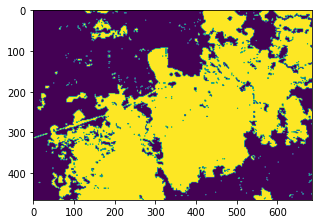

In [30]:
show_tiff(out_dir / "mask-orig.tiff")

The dark parts of this image are the pixels that were classified as class 4 or 5, and the other (light) pixels are the pixels we want to discard (replace with `NaN` = not a value).

Note that this mask image is a but noise and rough. We better expand the light area a bit to be a bit more conservative about which pixels are the usable ones.
We can implement this "dilation" by applying a gaussian blur and threshold opeartion.

First, create a simple gaussian kernel:

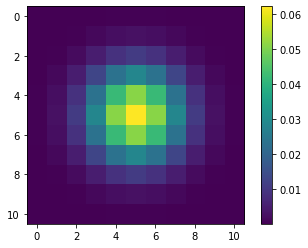

In [31]:
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()
im = plt.imshow(kernel)
plt.colorbar(im);

Convolve the mask image with the kernel and apply a threshold (note that we can use a regular comparison operator here):

In [32]:
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

In [33]:
mask.download(out_dir / "mask.tiff", format="GTiff")

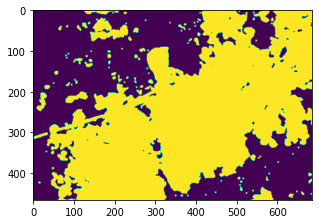

In [34]:
show_tiff(out_dir / "mask.tiff")

Great, we have a cleaner mask now.

Let's apply this mask to NDVI data. The masked pixels will get a `NaN` value.

In [35]:
red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

In [36]:
masked_ndvi.download(out_dir / "ndvi-masked.tiff", format="GTIFF")

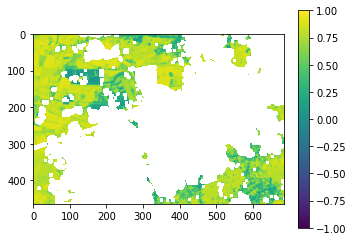

In [37]:
show_tiff(out_dir / "ndvi-masked.tiff", vmin=-1, vmax=1, add_colorbar=True)

The `NaN` values are show as white in this image, so that looks as desired.

# Time series

Next step: let's calculate a time series of the average NDVI in a couple of fields in this area.

First, load the fields as shapely geometries:

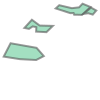

In [38]:
fields_geojson = '{"type": "GeometryCollection", "geometries": [{"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}, {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}, {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}, {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}]}'
fields = shapely.geometry.shape(json.loads(fields_geojson))
fields

Like before, we load like a data cube and calculate the NDVI, but we now use a larger time window covering of a couple of months.

Also note that we don't have to specify a bounding box explicitly when loading the cube,
because we will pass the desired fields in a next step, 
and the backend will limit the data loading to those areas appropriately.

In [39]:
dates = ("2020-06-01", "2020-10-01")

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", temporal_extent=dates, bands=["B04", "B08"])

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

With the `DataCube.aggregate_spatial()` method , we can calculate the mean NDVI for each of the fields.

In [40]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

We trigger execution by downloading the result. 
Because `DataCube.aggregate_spatial()` returns a timeseries (instead of raster data), we download it in JSON format.

In [41]:
timeseries.download(out_dir / "timeseries.json", format="JSON")

The openEO Python Client Library has a helper function `openeo.rest.conversions.timeseries_json_to_pandas` to convert the JSON structure to a pandas dataframe.

In [42]:
with open(out_dir / "timeseries.json") as f:
    ts = timeseries_json_to_pandas(json.load(f)).dropna()
ts.index = pd.to_datetime(ts.index)
ts.head()

polygon,0,1,2,3
date,,,,
2020-06-01 00:00:00+00:00,0.748476,0.495063,0.655510,0.486538
2020-06-04 00:00:00+00:00,0.028493,0.026855,0.026339,0.026769
2020-06-06 00:00:00+00:00,0.760013,0.501150,0.694817,0.394088
2020-06-11 00:00:00+00:00,0.024885,0.026817,0.028701,0.026536
2020-06-14 00:00:00+00:00,0.000000,0.000000,0.000000,0.000244


Let's plot the time series for these fields.

In [43]:
def plot_timeseries(filename):
    """Helper to plot the timeseries directly from JSON file"""
    with open(filename) as f:
        ts = timeseries_json_to_pandas(json.load(f)).dropna()
    ts.index = pd.to_datetime(ts.index)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ts.plot(marker='o', ax=ax)
    ax.set_title("Average NDVI"); ax.set_ylabel("NDVI");ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

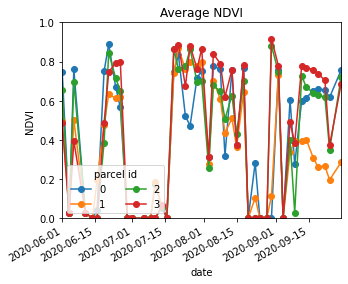

In [44]:
plot_timeseries(out_dir / "timeseries.json")

## Add cloud masking

The result above is a good start, but needs some work: there are quite some outliers and zero's that don't look right.
The reason for this are cloudy observations that cause unusable NDVI values.
We will add some cloud masking to generate a cleaner time series.



In [45]:
dates = ("2020-06-01", "2020-10-01")

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

In [46]:
masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [47]:
masked_timeseries.download(out_dir / "timeseries-masked.json", format="JSON")

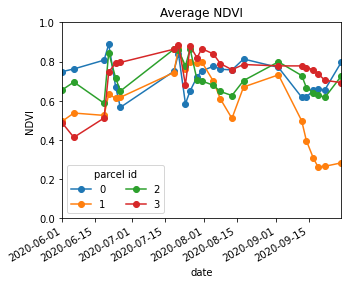

In [48]:
plot_timeseries(out_dir / "timeseries-masked.json")

That looks a lot cleaner now.

# Batch Jobs

If we want to cover a larger time window (or a larger geographical area), 
the synchronous `DataCube.download()` request we are doing above can take longer
because we are processing more data on the backend. 
This increases the risk that we will hit timeouts or other network issues.

It is therefor recommended to use batch jobs instead of synchronous execution 
for "large" requests (in terms of temporal or geographical coverage).
Let's illustrate that here with a time window of a couple of years:

In [49]:
dates = ("2018-01-01", "2021-03-20")

In [50]:
cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

masked_timeseries = masked_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

# We want to download the result in JSON format, which we have to specify here:
masked_timeseries = masked_timeseries.save_result(format="JSON")

We can now submit this a batch job:

In [51]:
job = masked_timeseries.create_job()

In [52]:
job.status()

'created'

The job is just created at the backend, it is not started automatically. We have to start it explicitly:

In [53]:
job.start_job()

In [54]:
job.status()

'queued'

We now have to wait for the job status to become "finished".
The openEO Python Client Library provides a way to actively wait for that.
Let's first stop the job we start.


In [55]:
job.stop_job()

In [56]:
job.status()

'canceled'

The `DataCube.execute_batch` helper method allows you to execute your algorithm as a batch job,
taking care of submitting and starting it, polling its status regularly,
and actively waiting till it is "finished" (or failed).

In [57]:
job = masked_timeseries.execute_batch()

0:00:00 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': send 'start'
0:00:55 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:01 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:08 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:17 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:27 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:40 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:01:56 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:02:16 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:02:41 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': queued (progress N/A)
0:03:11 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': running (progress N/A)
0:03:50 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': running (progress N/A)
0:04:37 Job '243e0f6f-f22a-4414-88d2-184bdefd4e9f': running (progress N/A)
0:05:36 Job '243e0f6f-f22a-4414-88d2-184bdef

In [58]:
job.status()

'finished'

When it's finished we can download the result. 
Note that a batch job can have multiple output files (assets), which is another advantage compared to synchronous download (which can only have a single result asset).

In [59]:
results = job.get_results()

This results object (`JobResults`), contains some metadata about the job result, for example:

In [60]:
results.get_metadata()["bbox"]

[5.053553857094518, 51.21689628072789, 5.085732850338428, 51.23646091560258]

The list of assets that can be downloaded is also define there:

In [61]:
print(results.get_assets())

[<ResultAsset 'out' (type application/json) at 'https://openeo.vito.be/openeo/1.0/jobs/243e0f6f-f22a-4414-88d2-184bdefd4e9f/results/out'>]


Because there is just one asset, we can download it easily as follows:

In [62]:
results.download_file(out_dir / "timeseries-large.json")

PosixPath('openeo-terrascope-webinar-results/timeseries-large.json')

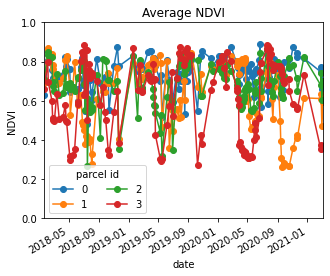

In [63]:
plot_timeseries(out_dir / "timeseries-large.json")

In this multi-year view of the NDVI timeseries we can observe some seasonal cycles and ploughing/harvesting operations.

# UDF: user-defined functions

As final step in this demonstration we will add a user-defined function (UDF) to the processing.
A UDF allows to submit a snippet of, for example, Python code to be executed on the data at the backend side.
First, load a data cube of masked NDVI data like before:

In [64]:
dates = ("2020-06-01", "2020-10-01")

cube = con.load_collection("TERRASCOPE_S2_TOC_V2", bands=["B04", "B08", "SCL"])
cube = cube.filter_temporal(dates)

classification = cube.band("SCL")
mask = ~ ((classification == 4) | (classification == 5))
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

red = cube.band("B04")
nir = cube.band("B08")
ndvi = (nir - red) / (nir + red)

masked_ndvi = ndvi.mask(mask)

We now use a UDF (user-defined function)
to interpolate the missing values 
and to apply a Savitzky-Golay filter for smoothing of the timeseries, using `scipy.signal.savgol_filter`.

In [65]:
udf_code = """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""

smoothed_ndvi = masked_ndvi.apply_dimension(code=udf_code, runtime="Python", dimension="t")

Now, aggregate this again per field and get the time series.

In [66]:
smoothed_timeseries = smoothed_ndvi.aggregate_spatial(geometries=fields, reducer="mean")

In [67]:
smoothed_timeseries.download(out_dir / "timeseries-smoothed.json", format="JSON")

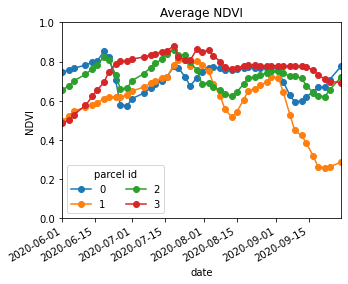

In [68]:
plot_timeseries(out_dir / "timeseries-smoothed.json")